<a href="https://colab.research.google.com/github/nv-hiep/text_recognition/blob/main/OCR_handwriting_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Handwriting Recognition with OCR (Optical character recognition)**

**Recognize numbers and Uppercase letters only:**

**'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'**

**'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'**

# 1. **Connect and authorize google drive with google colab:**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


## 1.1 **Open our project "Text Extraction" direct0ry in google drive:**

**Open our project "Text Extraction" direct0ry in google drive:**

In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/text_extraction/
!ls

/content/gdrive/My Drive/Colab Notebooks/text_extraction
data	ocr_data_gen.ipynb		 text_extraction_from_image.ipynb
models	OCR_with_Keras_Tensorflow.ipynb


# 2. Import libraries

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import os
import matplotlib
matplotlib.use('Agg')

# import the necessary packages
from models.resnet import ResNet

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers          import SGD
from sklearn.preprocessing                import LabelBinarizer
from sklearn.model_selection              import train_test_split
from sklearn.metrics                      import classification_report

from imutils                              import build_montages
from google.colab.patches                 import cv2_imshow

from tensorflow.keras.datasets            import mnist

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

import argparse
import cv2

%matplotlib inline

# 3. Load datasets and data preprocessing

## 3.1 Load data

In [ ]:
def load_az_dataset(datasetPath):
  # initialize the list of data and labels
  data   = []
  labels = []
  # loop over the rows of the A-Z handwritten digit dataset
  for row in open(datasetPath):
    # parse the label and image from the row
    row   = row.split(',')
    label = int(row[0])
    image = np.array([int(x) for x in row[1:]], dtype='uint8')

    # images are represented as single channel (grayscale) images
    # that are 28x28=784 pixels -- we need to take this flattened
    # 784-d list of numbers and repshape them into a 28x28 matrix
    image = image.reshape((28, 28))

    # update the list of data and labels
    data.append(image)
    labels.append(label)

  # convert the data and labels to NumPy arrays
  data   = np.array(data, dtype='float32')
  labels = np.array(labels, dtype='int')

  # return a 2-tuple of the A-Z data and labels
  return (data, labels)    

In [ ]:
def load_mnist_dataset():
  # load the MNIST dataset and stack the training data and testing
  # data together (we'll create our own training and testing splits
  # later in the project)
  ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
  
  data   = np.vstack([trainData, testData])
  labels = np.hstack([trainLabels, testLabels])

  # return a 2-tuple of the MNIST data and labels
  return (data, labels)

In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS  = 5
INIT_LR = 1.e-1
BS      = 128

# load the A-Z and MNIST datasets
print("[INFO] loading datasets...")
(azData, azLabels) = load_az_dataset('data/A_Z Handwritten Data.csv')
(digitsData, digitsLabels) = load_mnist_dataset()

[INFO] loading datasets...


In [ ]:
print( digitsLabels.shape )
digitsLabels

(70000,)


array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [ ]:
print( azLabels.shape )
azLabels

(372451,)


array([ 0,  0,  0, ..., 25, 25, 25])

## 3.2 Data preprocessing

Currently, our labels for A-Z go from [0, 25], corresponding to each letter of the alphabet. The labels for our digits go from 0-9, so there is overlap — which would be a problematic if we were to just combine them directly.

No problem! There is a very simple fix. We will just add ten to all of our A-Z labels so they all have integer label values greater than our digit label values. Now, we have a unified labeling schema for digits 0-9 and letters A-Z without any overlap in the values of the labels.

In [ ]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
azLabels += 10

# stack the A-Z data and labels with the MNIST digits data and labels
data   = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

print('Shape before expanding dimensions')
print(data.shape)

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data  = np.expand_dims(data, axis=-1)
data /= 255.

print('Shape after expanding dimensions')
print(data.shape)

Shape before expanding dimensions
(442451, 32, 32)
Shape after expanding dimensions
(442451, 32, 32, 1)


Our next step is to prepare the labels for ResNet, weight the labels to account for the skew in the number of times each class (character) is represented in the data, and partition the data into test and training splits:

In [ ]:
# convert the labels from integers to vectors
le     = LabelBinarizer()
labels = le.fit_transform(labels) # shape of labels = (442451, 36)
counts = labels.sum(axis=0)       # Sum over all rows

print(labels.shape)
print(counts)
labels

(442451, 36)
[ 6903  7877  6990  7141  6824  6313  6876  7293  6825  6958 13870  8668
 23409 10134 11440  1163  5762  7218  1120  8493  5603 11586 12336 19010
 57825 19341  5812 11566 48419 22495 29008  4182 10784  6272 10859  6076]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
labels[5]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# account for skew in the labeled data
class_totals = labels.sum(axis=0)
class_totals

array([ 6903,  7877,  6990,  7141,  6824,  6313,  6876,  7293,  6825,
        6958, 13870,  8668, 23409, 10134, 11440,  1163,  5762,  7218,
        1120,  8493,  5603, 11586, 12336, 19010, 57825, 19341,  5812,
       11566, 48419, 22495, 29008,  4182, 10784,  6272, 10859,  6076])

In [ ]:
# loop over all classes and calculate the class weight
class_weight = {}
for i in range(0, len(class_totals)):
	class_weight[i] = class_totals.max() / class_totals[i]

class_weight

{0: 8.376792698826597,
 1: 7.340992763742541,
 2: 8.272532188841202,
 3: 8.097605377398123,
 4: 8.473769050410317,
 5: 9.15967052114684,
 6: 8.409685863874346,
 7: 7.928835870012341,
 8: 8.472527472527473,
 9: 8.310577752227651,
 10: 4.169069935111752,
 11: 6.671089063221043,
 12: 2.4702037677816224,
 13: 5.7060390763765545,
 14: 5.0546328671328675,
 15: 49.72055030094583,
 16: 10.035577924331829,
 17: 8.011221945137157,
 18: 51.629464285714285,
 19: 6.808548216178029,
 20: 10.320364090665715,
 21: 4.990937338166753,
 22: 4.6875,
 23: 3.0418200946870066,
 24: 1.0,
 25: 2.989762680316426,
 26: 9.94924294562973,
 27: 4.999567698426422,
 28: 1.1942625828703608,
 29: 2.5705712380529007,
 30: 1.993415609487038,
 31: 13.827116212338593,
 32: 5.362110534124629,
 33: 9.21954719387755,
 34: 5.3250759738465785,
 35: 9.51695194206715}

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
# stratify=labels -> training and test subsets have the same proportions of class labels as the input dataset
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20,
                                                  stratify=labels,
                                                  random_state=42)

In [ ]:
aug = ImageDataGenerator(rotation_range=10,
                         zoom_range=0.05,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.15,
                         horizontal_flip=False,
                         fill_mode='nearest')

# 4. ResNet Model and training

 Initialize and compile the ResNet network

compile our model with "categorical_crossentropy" loss and our established SGD optimizer. Please beware that if you are working with a 2-class only dataset (we are not), you would need to use the "binary_crossentropy" loss function.

In [ ]:
# initialize and compile our deep neural network
print('[INFO] compiling model...')

opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# params: width,height,depth,classes,stage,filters,reg = 0.0001,bnEps=2e-5,bnMom=0.9,dataset='cifar'
# where: inputShape = (height,width,depth)
#        epsilon = bnEps, momentum = bnMom
#        kernel_regularizer=l2(reg)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
                     (64, 64, 128, 256), reg=0.0005)

model.compile(loss='categorical_crossentropy', optimizer=opt,	metrics=['accuracy'])

model.summary()

[INFO] compiling model...
Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   576         batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d[0][0]                     
___________________________________________________________________

Note: Formerly, TensorFlow/Keras required use of a method called .fit_generator in order to train a model using data generators (such as data augmentation objects). Now, the .fit method can handle generators/data augmentation as well, making for more-consistent code. This also applies to the migration from .predict_generator to .predict. 

In [ ]:
# train the network - It takes time, so I train 5 epochs ONLY
print('[INFO] training network...')

history = model.fit(aug.flow(trainX, trainY, batch_size=BS),
                    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
                    epochs=EPOCHS,
                    class_weight=class_weight,
                    verbose=True)

[INFO] training network...
Epoch 1/5
2765/2765 [==============================] - 7486s 3s/step - loss: 4.9023 - accuracy: 0.7286 - val_loss: 0.5526 - val_accuracy: 0.9043
Epoch 2/5
2765/2765 [==============================] - 7455s 3s/step - loss: 1.4312 - accuracy: 0.9002 - val_loss: 0.5229 - val_accuracy: 0.9040
Epoch 3/5
2765/2765 [==============================] - 7491s 3s/step - loss: 1.2990 - accuracy: 0.9082 - val_loss: 0.5267 - val_accuracy: 0.8980
Epoch 4/5
2765/2765 [==============================] - 7463s 3s/step - loss: 1.2245 - accuracy: 0.9142 - val_loss: 0.5328 - val_accuracy: 0.8911
Epoch 5/5
2765/2765 [==============================] - 7373s 3s/step - loss: 1.1969 - accuracy: 0.9140 - val_loss: 0.5408 - val_accuracy: 0.8873


In [ ]:
# Save the trained model
model.save('models/Handwriting.model', save_format='h5')

# define the list of label names
label_names = '0123456789'
label_names += 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
label_names = [x for x in label_names]

# evaluate the network
print('[INFO] evaluating network...')
predictions = model.predict(testX, batch_size=BS)

print(classification_report(testY.argmax(axis=1),	predictions.argmax(axis=1), target_names=label_names))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.17      0.87      0.28      1381
           1       0.97      0.96      0.96      1575
           2       0.85      0.96      0.90      1398
           3       0.91      0.98      0.95      1428
           4       0.80      0.95      0.87      1365
           5       0.55      0.91      0.68      1263
           6       0.91      0.97      0.94      1375
           7       0.90      0.97      0.94      1459
           8       0.87      0.97      0.92      1365
           9       0.94      0.98      0.96      1392
           A       0.99      0.98      0.98      2774
           B       0.96      0.96      0.96      1734
           C       0.99      0.96      0.98      4682
           D       0.91      0.95      0.93      2027
           E       0.99      0.97      0.98      2288
           F       0.95      0.98      0.97       232
           G       0.90      0.94      0.92      115

We will save the model to disk, plot the results of the training history, and save the training history:

[INFO] serializing network...


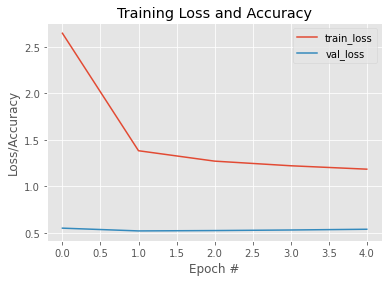

In [ ]:
# save the model to disk
print("[INFO] serializing network...")
model.save('models/Handwriting.model2', save_format='h5')

# Figure: construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, history.history['loss'], label='train_loss')
plt.plot(N, history.history['val_loss'], label='val_loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('data/plot.png')
plt.show()

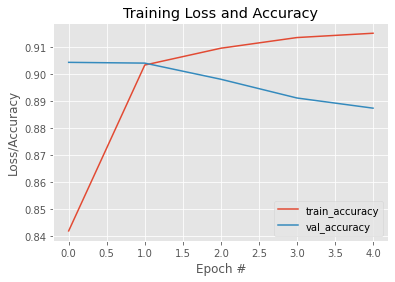

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, history.history['accuracy'], label='train_accuracy')
plt.plot(N, history.history['val_accuracy'], label='val_accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('data/plot_acc.png')
plt.show()

Finally, let’s code our visualization procedure so we can see whether our model is working or not:

In [ ]:
# initialize our list of output test images
images = []

# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
  # classify the character
  probs      = model.predict(testX[np.newaxis, i])
  prediction = probs.argmax(axis=1)
  label      = label_names[prediction[0]]

  # extract the image from the test data and initialize the text
  # label color as green (correct)
  image = (testX[i] * 255).astype('uint8')
  color = (0, 255, 0)   # green

  # otherwise, the class label prediction is incorrect
  if prediction[0] != np.argmax(testY[i]):
    color = (0, 0, 255)  # red

  # merge the channels into one image, resize the image from 32x32
  # to 96x96 so we can better see it and then draw the predicted
  # label on the image
  image = cv2.merge([image] * 3)
  image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
    color, 2)

  # add the image to our list of output images
  images.append(image)

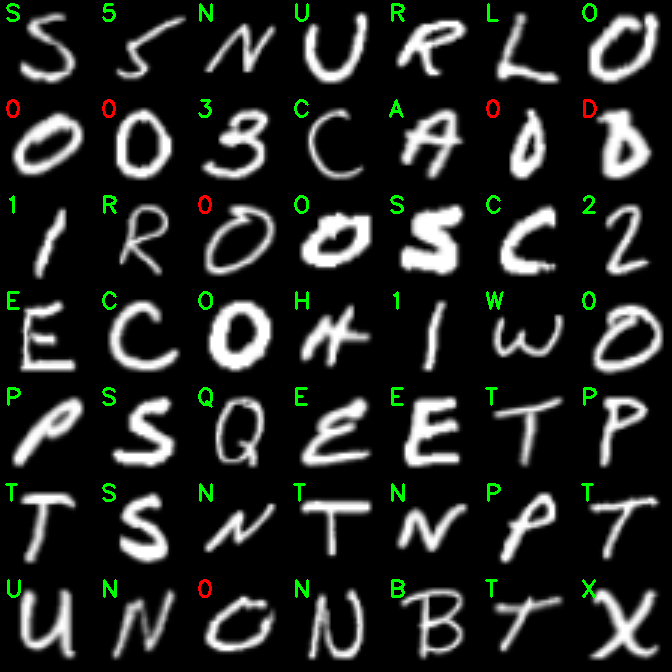

-1

In [ ]:
# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]

# show the output montage
# cv2.imshow('OCR Results', montage)
cv2_imshow(montage)
cv2.waitKey(0)